### Continuous Fourier Transform & FFT

\begin{aligned}
\hat{f}\left(k\right) &=\frac{1}{\sqrt{2\pi}}\int f\left(x\right)e^{-ikx}dx\approx\frac{1}{\sqrt{2\pi}}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-ikj\Delta x}\Delta x \\
	&=\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\sqrt{2\pi}kj\frac{\Delta x}{\sqrt{2\pi}}}\frac{\Delta x}{\sqrt{2\pi}}\to f\left(k_{n}\right)=\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\sqrt{2\pi}\left(n\frac{2\pi}{N\Delta x}\right)j\frac{\Delta x}{\sqrt{2\pi}}}\frac{\Delta x}{\sqrt{2\pi}} \\
	&=\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\frac{2\pi nj}{N}}\frac{\Delta x}{\sqrt{2\pi}} \\
	&=\frac{L}{\sqrt{2\pi N}}\left[\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\frac{2\pi nj}{N}}\right] \\
	&=\frac{L}{\sqrt{2\pi}}\left[\frac{1}{N}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\frac{2\pi nj}{N}}\right]
\end{aligned}

If $L=1, \hat{f}\left(k\right)=\frac{1}{\sqrt{2\pi N}}\text{fft}_{\text{ortho}}\left(f\right)=\frac{1}{\sqrt{2\pi}}\text{fft}_{\text{forward}}\left(f\right)=\frac{1}{\sqrt{2\pi}N}\text{fft}_{\text{backward}}\left(f\right)$.

In Numpy FFT lib, the **default** normalization ("backward") has the direct (forward) transforms unscaled and the inverse (backward) transforms scaled by $\frac{1}{N}$. For normalization "ortho" both direct and inverse transforms are scaled by $\sqrt{N}$. For normalization "forward" the direct transforms scaled by $\frac{1}{N}$ and the inverse transforms unscaled.

For even $N$, Nyquist frequency is at index $N/2$ (negative);

For odd $N$, index $\frac{N-1}{2}$ denotes the largest positive frequency, while $\frac{N+1}{2}$ denotes the largest negative frequency (absolute value here). 

The index $k<\frac{N}{2}$ corresponds to a positive frequency $\frac{k}{N}$, the index $k\ge\frac{N}{2}$ corresponds to a negative frequency $\frac{k-N}{N}$

In [1]:
import numpy as np
from numpy import fft

#### examples for the FFT module ####
N = 10
k_fft = fft.fftfreq(N)*2*np.pi  # Nyquist frequency = \pi, one period = 2\pi
print(k_fft)
N = 11
k_fft = fft.fftfreq(N)*2*np.pi  # Nyquist frequency = \pi, one period = 2\pi
print(k_fft)

[ 0.          0.62831853  1.25663706  1.88495559  2.51327412 -3.14159265
 -2.51327412 -1.88495559 -1.25663706 -0.62831853]
[ 0.          0.57119866  1.14239733  1.71359599  2.28479466  2.85599332
 -2.85599332 -2.28479466 -1.71359599 -1.14239733 -0.57119866]


### Contour Fitting Function

In [ ]:
##  Plot Fluctuating Flat Interface ##
import yt
import numpy as np
from skimage import measure

def ih_direct(profile, level = 0):
    """
    Calculates the interface height in the z-direction for a system with a flat interface across the xy plane.

    This function determines the z-coordinate of the interface at each point in the xy plane by identifying where the isocontour of the interface is zero. It uses the `skimage.measure.find_contours` function to perform this calculation.

    Parameters
    ----------
    profile : numpy.ndarray
        A 3D NumPy array representing the order parameter of the system. The array has dimensions `(nx, ny, nz)`, where `nx` is the size in the x-direction and `ny` and `nz` are the sizes in the y- and z-directions, respectively.
           
           z (height)
           |
     _ _ _ |_ _ _ _ _ _ _ _ 
           |__ __ __ y (stripe length)
     _ _ _/__ _ _ _ _ _ _ _ 
         /
        /
       x (thickness of the interface is in the x-direction)
    """
    nx, ny, nz = profile.shape
    index_levels = np.arange(0, ny, 1)
    out = np.zeros((nx, ny))
    for x in range(nx):
        levels = measure.find_contours(profile[x, :, :], level = level)[1]
        #print(levels)
        idxs = np.isin(levels[:, 0], index_levels)
        #print(idxs.shape)
        out[x,:] = levels[idxs, 1]
        #print(out[x].shape)
    return out

# Example usage
alpha0 = 1.5
temperature = 0.
nx = 8
ny = 256
nz = 64
frameIdx = 2000
rho_lo = 0.1
rho_hi = 2.

file_path = "./data_interface/lbm_data_shshan_alpha0_" + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
ts = yt.load(file_path)
profile_data = ts.covering_grid(
    level=0, left_edge=ts.domain_left_edge, dims=ts.domain_dimensions
)
print(ts.field_list)
profile = profile_data['boxlib', 'rho']
print("input data has shape ", profile.shape)

height = ih_direct(profile, (rho_lo + rho_hi)/2.)
print(height)

### Spectrum of height fluctuations $h$ of a flat interface

$$\left\langle \left|\hat{h}\left(k\right)\right|^{2}\right\rangle =\frac{k_{B}T}{C^2_{invf}\gamma k^{2}}$$

##### Proof

Free energy of fluctuating flat interface
$$F=\gamma S$$
in which $S$ denotes surface area. The surface area element is
\begin{aligned}
S	=\int\left|\frac{\partial\bm{r}}{\partial x}\times\frac{\partial\bm{r}}{\partial y}\right|dxdy=\int\left|\begin{array}{ccc}
\bm{i} & \bm{j} & \bm{k}\\
1 & 0 & \frac{\partial h}{\partial x}\\
0 & 1 & \frac{\partial h}{\partial y}
\end{array}\right|dxdy
	=\int\left|-\frac{\partial h}{\partial x}\bm{i}-\frac{\partial h}{\partial y}\bm{j}+\bm{k}\right|dxdy
	=\int\sqrt{1+\left|\nabla h\left(x,y\right)\right|^{2}}dxdy
\end{aligned}

Therefore the free energy is
$$\Delta F=\gamma\Delta S\approx\frac{\gamma}{2}\int\left|\nabla h\left(x,y\right)\right|^{2}dxdy=\frac{\gamma}{2}C_{invf}^{2}\int\left|i\bm{k}\hat{h}\left(\bm{k}\right)\right|^{2}d\bm{k}$$

By FDT, $Z\sim e^{-\beta\Delta F}$, each ~$\left|\bm{k}\right|^2$ term possesses $\frac{k_BT}{2}$.
$$\frac{\gamma}{2}C_{invf}^{2}\left|\bm{k}\right|^{2}\left\langle \left|\hat{h}\left(\bm{k}\right)\right|^{2}\right\rangle =\frac{1}{2}k_{B}T$$
$$\to\ \ \ \ \left\langle \left|\hat{h}\left(\bm{k}\right)\right|^{2}\right\rangle =\frac{k_{B}T}{C_{invf}^{2}\gamma\left|\bm{k}\right|^{2}}$$

If we set $C_{invf}=1$


### ensemble average for $\left\langle \left|\hat{h}\left(k\right)\right|^{2}\right\rangle$


In [ ]:
###   Read in height ensembles from step1 to step2 ###

step1 = 300000
step2 = 600000
plot_int = 2000 # interval between frames
alpha0 = 1.5
temperature = 1e-5
nx = 8
ny = 256
nz = 64
rho_lo = 0.1
rho_hi = 2.

sliceIdx_x = 4
height_arrays = np.zeros(((step2 - step1) // plot_int + 1, ny))
for n in range(step1, step2+plot_int, plot_int):
    plot_file_dir = "./data_interface/lbm_data_shshan_alpha0_" + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{n:07d}"
    ds = yt.load(plot_file_dir)
    profile = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
    profile_data = profile['boxlib', 'rho']
    height = ih_direct(profile_data, (rho_lo + rho_hi)/2.)
    height_arrays[(n - step1) // plot_int, :] = height[sliceIdx_x, :]

print(height_arrays)


/tmp/ipykernel_257711/2995224456.py:9: RuntimeWarning: divide by zero encountered in divide
  ky_fft2_inv = 1./(ky_fft*ky_fft.conjugate())


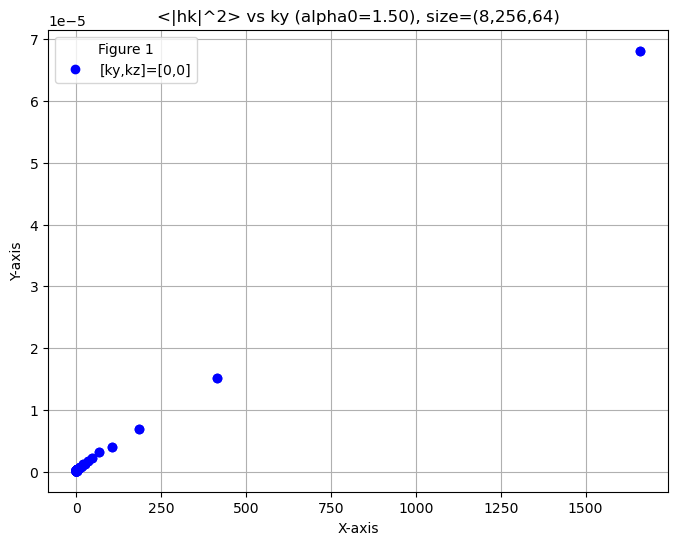

In [ ]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt

fft_mode = "forward"

h_k_norm2 = np.zeros((ny), dtype = np.complex128)
ky_fft = fft.fftfreq(ny)*2*np.pi
ky_fft2_inv = 1./(ky_fft*ky_fft.conjugate())
h_mean = np.mean(height_arrays, axis=0)  # Mean height profile across the ensemble

# height_arrays = np.zeros(((step2 - step1) // plot_int + 1, ny))
for n in range(height_arrays.shape[0]):
    h = height_arrays[n, :] - h_mean
    h_k = fft.fft(h, norm = fft_mode)
    h_k_norm2 += h_k*h_k.conjugate()
h_k_norm2 /= height_arrays.shape[0]  # Average over the ensemble

plt.figure(1, figsize=(8, 6), dpi=100)  # Optional: Set the figure size
#fig, ax = plt.subplots()
plt.plot(ky_fft2_inv, h_k_norm2, label="[ky,kz]=[0,0]", marker='o', linestyle='', color='b') 
plt.legend(title="Figure 1")

plt.xlabel("X-axis")  # X-axis label
plt.ylabel("Y-axis")  # Y-axis label
plt.title("<|hk|^2> vs ky (alpha0={:.2f}), size=({:d},{:d},{:d})".format(alpha0,nx,ny,nz))  # Plot title
#plt.ylim(0,1.2)
plt.grid(True)
